In [1]:
# Imports & Setup:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

from google.colab import drive
drive.mount('/content/drive')

import tarfile

fname = "/content/drive/MyDrive/CUB_200_2011.tgz"
fobj = tarfile.open(fname, "r")
fobj.extractall("/content")
fobj.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# function to load in and process images
def load_image(path):
    images = Image.open(f'/content/CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

In [3]:
class_map_dir= pd.read_csv('/content/drive/MyDrive/Bird-Classifications/Tables/class_map_dir_output_new_classes_f.csv')

In [4]:
species_names=[
"Albatrosses",
"Auks",
"Cardinals, Allies",
"Cormorants and Shags",
"Crows, Jays, Magpies",
"Cuckoos",
"Ducks, Geese, Waterfowl",
"Finches, Euphonias, Allies",
"Frigates",
"Grebes",
"Gulls, Terns, Skimmers",
"Hummingbirds",
"Kingfishers",
"Larks",
"Loons",
"Mickingbirds and Thrashers",
"New World Sparrows",
"New World Warblers",
"Nightjars and Allies",
"Nuthatches",
"Pelicans",
"Shearwaters and Petrels",
"Shrikes",
"Skuas and Jaegers",
"Starlings",
"Swallows",
"Treecreepers",
"Troupials and Allies",
"Tyrant Flycatchers",
"Vireos, Shrike-Babblers, Erpornis",
"Wagtails and Pipits",
"Waxwings",
"Woodpeckers",
"Wrens",
"Yellow-breasted Chat"
]

In [5]:
class_map_dir_train=class_map_dir.loc[class_map_dir['Is Training Image']==1]
list_of_images_train=[load_image(i) for i in class_map_dir_train['Image Name']]
array_of_img_train=np.asarray(list_of_images_train)
list_of_labels_train=class_map_dir_train['Species_Num_Seq']

class_map_dir_test=class_map_dir.loc[class_map_dir['Is Training Image']==0]
list_of_images_test=[load_image(i) for i in class_map_dir_test['Image Name']]
array_of_img_test=np.asarray(list_of_images_test)
list_of_labels_test=class_map_dir_test['Species_Num_Seq']

# sanity check length of train datasets
print(len(list_of_images_train))
print(len(list_of_labels_train))

# sanity check length of test datasets
print(len(list_of_images_test))
print(len(list_of_labels_test))

5994
5994
5794
5794


In [6]:
X_train_alt=array_of_img_train
y_train_alt=list_of_labels_train

X_test_alt=array_of_img_test
y_test_alt=list_of_labels_test

X_train_alt = X_train_alt.reshape(X_train_alt.shape[0], 128, 128, 3)
X_test_alt = X_test_alt.reshape(X_test_alt.shape[0], 128, 128, 3)
y_train_alt = utils.to_categorical(y_train_alt,36)
y_test_alt = utils.to_categorical(y_test_alt,36)

In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
#base_model.summary()

In [8]:
model_g = Sequential([ base_model,
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model_g.add(Flatten(input_shape = (128, 128, 3)))
model_g.add(Dense(512, activation = 'relu'))
model_g.add(Dense(256, activation = 'relu'))
model_g.add(Dense(128, activation = 'relu'))
model_g.add(Dense(128, activation = 'relu'))
model_g.add(Dense(64, activation = 'relu'))
model_g.add(Dense(48, activation = 'relu'))

model_g.add(Dense(36, activation = 'softmax'))
# Compile model.
model_g.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_g.trainable = True
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience = 5, verbose = 1, mode = 'auto')
history_g  = model_g.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=50,
                    verbose=1,
                    callbacks = [early_stop])

Epoch 1/50
24/24 [==============================] - 17s 273ms/step - loss: 2.8176 - accuracy: 0.2933 - val_loss: 2.2185 - val_accuracy: 0.4025
Epoch 2/50
24/24 [==============================] - 4s 183ms/step - loss: 1.9375 - accuracy: 0.4630 - val_loss: 1.7953 - val_accuracy: 0.5054
Epoch 3/50
24/24 [==============================] - 4s 183ms/step - loss: 1.5228 - accuracy: 0.5512 - val_loss: 1.6621 - val_accuracy: 0.5119
Epoch 4/50
24/24 [==============================] - 4s 158ms/step - loss: 1.2594 - accuracy: 0.6268 - val_loss: 1.5694 - val_accuracy: 0.5535
Epoch 5/50
24/24 [==============================] - 4s 159ms/step - loss: 1.0307 - accuracy: 0.6877 - val_loss: 1.5067 - val_accuracy: 0.5796
Epoch 6/50
24/24 [==============================] - 4s 159ms/step - loss: 0.8409 - accuracy: 0.7421 - val_loss: 1.5017 - val_accuracy: 0.5868
Epoch 7/50
24/24 [==============================] - 4s 158ms/step - loss: 0.6950 - accuracy: 0.7851 - val_loss: 1.5791 - val_accuracy: 0.5734
Epoch

In [9]:
# Prep data for confusion matrix
predictions=model_g.predict(X_test_alt) 
pred_f=np.argmax(predictions,axis=1)
y_test_f=np.argmax(y_test_alt,axis=1)

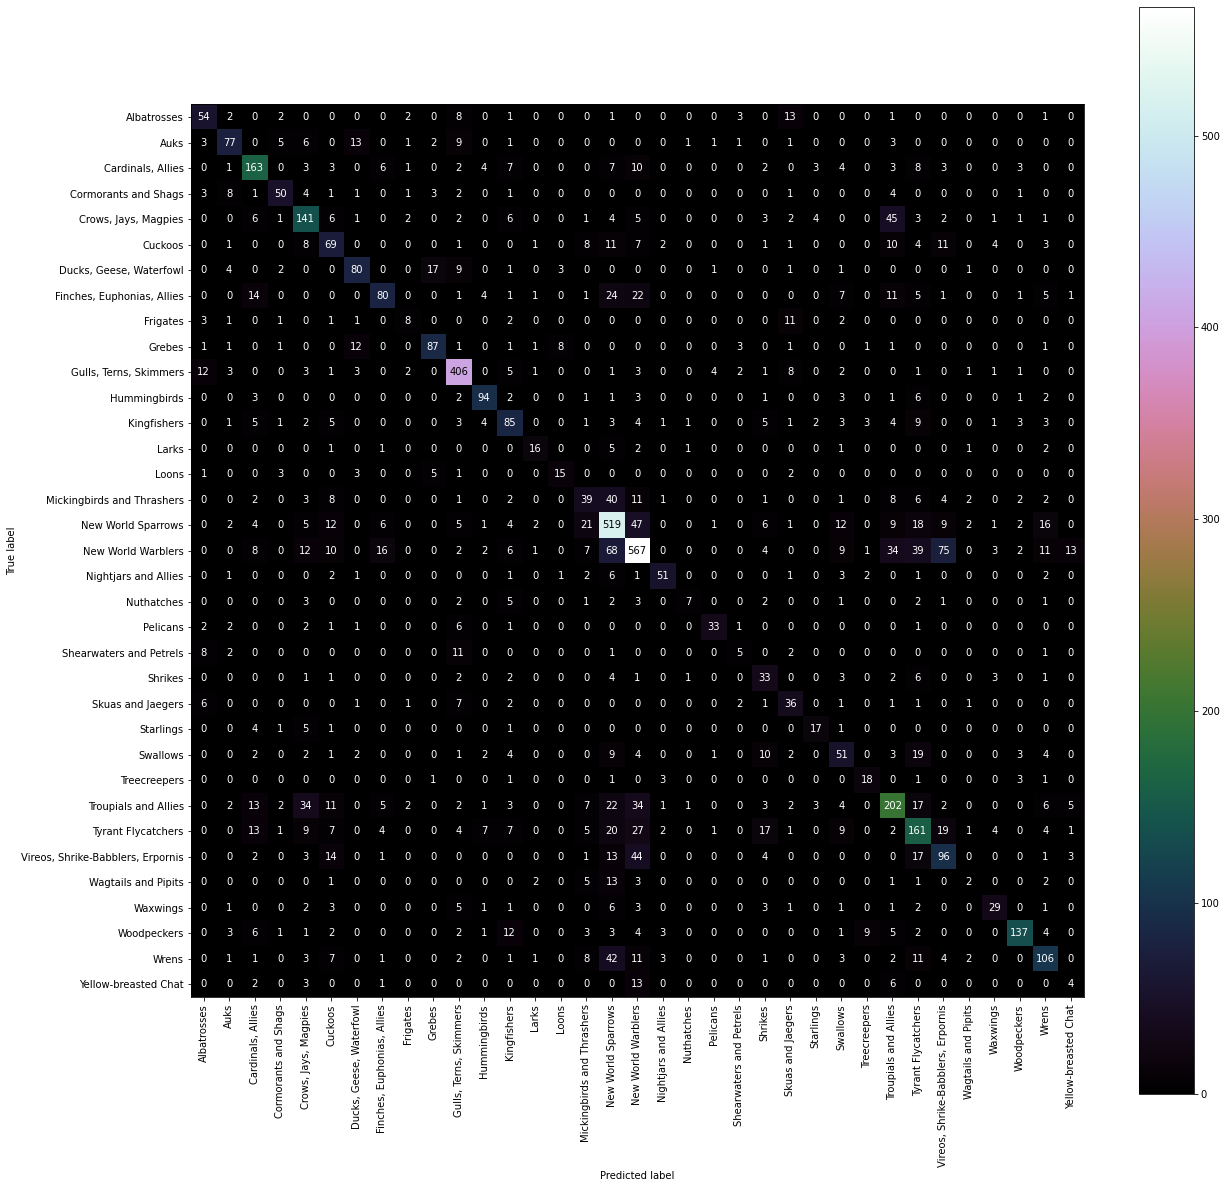

In [10]:
cm = metrics.confusion_matrix(y_test_f, pred_f) #set normalize = true to see the % distribution by row 
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_names)
disp.plot(ax=ax, cmap='cubehelix')
plt.xticks(rotation=90);

In [11]:
model_g.save('saved_models/species_est_g.h5')